In [79]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd")

In [80]:
nyc_crime_raw = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv')

In [81]:
nyc_crime_raw.head(5)

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0


In [82]:
#Looks like there was descriptive text at the top of the file and the actual columns are seen in row 3 above.
#First rename the columns

nyc_crime_raw.columns = ['City', 'Population', 'Violent Crime', 'Murder', 'Rape1', 'Rape2', 'Robbery', 
                     'Aggravated Assault', 'Property Crime', 'Burglary', 'Larceny Theft', 'Motor Vehicle Theft',
                    'Arson']

In [83]:
#Confirm the new columns are persisted

nyc_crime_raw.head(5)

,City,Population,Violent Crime,Murder,Rape1,Rape2,Robbery,Aggravated Assault,Property Crime,Burglary,Larceny Theft,Motor Vehicle Theft,Arson
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0


In [84]:
#Now drop superfluous rows

nyc_crime = nyc_crime_raw.iloc[4:]

In [85]:
#Confirm row drop worked

nyc_crime.head(5)

,City,Population,Violent Crime,Murder,Rape1,Rape2,Robbery,Aggravated Assault,Property Crime,Burglary,Larceny Theft,Motor Vehicle Theft,Arson
4,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0
5,Addison Town and Village,"2,577",3,0,NaN,0,0,3,24,3,20,1,0
6,Akron Village,"2,846",3,0,NaN,0,0,3,16,1,15,0,0
7,Albany,"97,956",791,8,NaN,30,227,526,"4,090",705,"3,243",142,NaN
8,Albion Village,"6,388",23,0,NaN,3,4,16,223,53,165,5,NaN


In [86]:
#Describe the DataFrame

nyc_crime.describe()

,City,Population,Violent Crime,Murder,Rape1,Rape2,Robbery,Aggravated Assault,Property Crime,Burglary,Larceny Theft,Motor Vehicle Theft,Arson
count,351,348,348,348,0.000,348,348,348,348,348,348,348,187
unique,351,347,82,14,0.000,26,51,69,239,124,232,51,13
top,Gowanda Village,"9,517",0,0,nan,0,0,0,0,0,0,0,0
freq,1,2,51,299,nan,204,139,66,6,21,7,93,133


In [119]:
#Describe our columns of interest

nyc_crime['Property Crime'].describe()

count    330.000
mean     219.612
std      279.969
min        0.000
25%       38.000
50%      105.000
75%      309.250
max     1353.000
Name: Property Crime, dtype: float64

In [88]:
nyc_crime.shape

(351, 13)

In [89]:
#Now that we know we have 351 observations across 13 columns, let's Find NaN's by column

missing_values_count = nyc_crime.isnull().sum()
print(missing_values_count)

City                     0
Population               3
Violent Crime            3
Murder                   3
Rape1                  351
Rape2                    3
Robbery                  3
Aggravated Assault       3
Property Crime           3
Burglary                 3
Larceny Theft            3
Motor Vehicle Theft      3
Arson                  164
dtype: int64


In [90]:
#Drop NaN's in the columns we care most about

nyc_crime = nyc_crime.dropna(subset=['Population', 'Murder', 'Robbery', 'Property Crime'])

In [91]:
#Rename 'Rape2' to just 'Rape'

#Disable warning when making changes on a slice of original dataframe
pd.options.mode.chained_assignment = None

nyc_crime.rename(columns={'Rape2': 'Rape'}, inplace=True)

In [92]:
#Drop Rape1 since it contains no data

nyc_crime.drop(columns=['Rape1'], inplace=True)

### Now that data is clean, begin creating/converting features for Population Squared, Murder and Robbery

In [93]:
#To create population squared feature, first remove commas from amounts
nyc_crime['Population'] = nyc_crime['Population'].str.replace(',', '')

In [94]:
#Next, convert column from string to int

nyc_crime['Population'] = nyc_crime['Population'].astype(int)

In [95]:
#Now we can create our new feature!

nyc_crime['Population Squared'] = nyc_crime['Population']**2

In [96]:
#Confirm this worked

nyc_crime[['Population', 'Population Squared']].head(5)

,Population,Population Squared
4,1861,3463321
5,2577,6640929
6,2846,8099716
7,97956,9595377936
8,6388,40806544


In [97]:
#To convert 'Murder' column, first need to convert from string to int

nyc_crime['Murder'] = nyc_crime['Murder'].astype(int)

In [98]:
#Now lets change our 'Murder' column to categorical (0 or 1)

nyc_crime['Murder'] = np.where((nyc_crime['Murder'] > 0), 1, 0)

In [99]:
#To create converted 'Robbery' column, need to remove commas first

nyc_crime['Robbery'] = nyc_crime['Robbery'].str.replace(',', '')

In [100]:
#Similarly to population and murder, to convert 'Robbery' column, first need to convert from string to int

nyc_crime['Robbery'] = nyc_crime['Robbery'].astype(int)

In [101]:
#Now lets change our 'Robbery' column to categorical (0 or 1)

nyc_crime['Robbery'] = np.where((nyc_crime['Robbery'] > 0), 1, 0)

In [102]:
#Finally, remove commas in property crime

nyc_crime['Property Crime'] = nyc_crime['Property Crime'].str.replace(',', '')

In [103]:
#Change property crime from string to int
nyc_crime['Property Crime'] = nyc_crime['Property Crime'].astype(int)

In [104]:
#Because Property Crime has an extreme outlier of 141,971, let's work to remove that.

nyc_crime['Property Crime'].quantile(0.95)

1377.6999999999991

In [105]:
#Alter dataframe
nyc_crime = nyc_crime[nyc_crime['Property Crime'] < 1378]

### Now that features are prepared, let's create our regression model

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

In [106]:
# Instantiate and fit our model.
regression = linear_model.LinearRegression()
Y = nyc_crime['Property Crime']
X = nyc_crime[['Population','Population Squared','Murder', 'Robbery']]
regression.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regression.coef_)
print('\nIntercept: \n', regression.intercept_)
print('\nR-squared:')
print(regression.score(X, Y))


Coefficients: 
 [ 2.18579570e-02 -1.39074654e-07  1.19444585e+02  7.41670954e+01]

Intercept: 
 -45.96339804765523

R-squared:
0.6869869633189828


### Working through assumptions

**Assumption One:** Linear Relationship with all variables

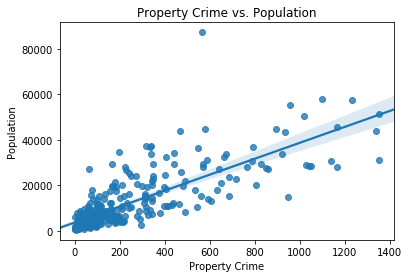

In [114]:
#Now test if Population is linear

sns.regplot(x='Property Crime', y='Population', data=nyc_crime)
plt.title('Property Crime vs. Population')
plt.show()

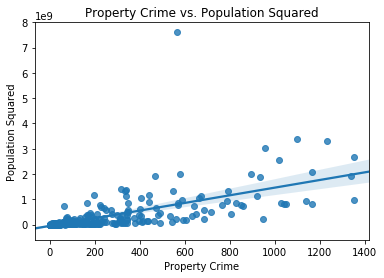

In [113]:
#Test if Population Squared is linear

sns.regplot(x='Property Crime', y='Population Squared', data=nyc_crime)
plt.title('Property Crime vs. Population Squared')
plt.show()

**Assumption Two:** Multivariate Normality

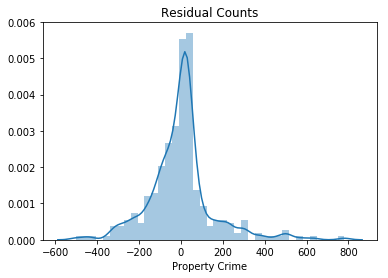

In [112]:
# Extract predicted values.
predicted = regression.predict(X).ravel()
actual = nyc_crime['Property Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

sns.distplot(residual)
plt.title('Residual Counts')
plt.show()

**Assumption Three:** Homoscedasticity

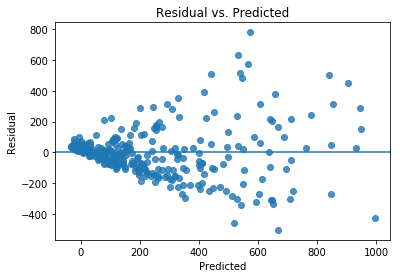

In [110]:
#Plotting residual vs. predicted

sns.regplot(x=predicted, y=residual, fit_reg=False)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

**Assumption Four:** Low Multicollinearity

In [111]:
#Correlation matrix

correlation_matrix = X.corr()
display(correlation_matrix)

,Population,Population Squared,Murder,Robbery
Population,1.000,0.904,0.486,0.472
Population Squared,0.904,1.000,0.463,0.310
Murder,0.486,0.463,1.000,0.279
Robbery,0.472,0.310,0.279,1.000
